# Calculating a custom statistic

This example shows how to define and use a custom `iris.analysis.Aggregator`, that provides a new statistical operator for
use with cube aggregation functions such as `~iris.cube.Cube.collapsed`, `~iris.cube.Cube.aggregated_by` or `~iris.cube.Cube.rolling_window`.

In this case, we have a 240-year sequence of yearly average surface temperature over North America, and we want to calculate in how many years these exceed a certain temperature over a spell of 5 years or more.

Define a function to perform the custom statistical operation.

Note: in order to meet the requirements of `iris.analysis.Aggregator`, it must do the calculation over an arbitrary (given) data axis.

A function defined in a notebook will have to be defined in a single cell. Splitting it across multiple cells makes it separate code blocks, not one function.  
Notebooks are thus not designed to write a lot of functions. If you do happen to need to do this, consider creating a separate Python module and importing the functions from there.

In [12]:
import numpy as np
from iris.util import rolling_window
def count_spells(data, threshold, axis, spell_length):
    """
    Function to calculate the number of points in a sequence where the value
    has exceeded a threshold value for at least a certain number of timepoints.

    Generalised to operate on multiple time sequences arranged on a specific
    axis of a multidimensional array.

    Args:

    * data (array):
        raw data to be compared with value threshold.

    * threshold (float):
        threshold point for 'significant' datapoints.

    * axis (int):
        number of the array dimension mapping the time sequences.
        (Can also be negative, e.g. '-1' means last dimension)

    * spell_length (int):
        number of consecutive times at which value > threshold to "count".

    """
    if axis < 0:
        # just cope with negative axis numbers
        axis += data.ndim
        

    # Threshold the data to find the 'significant' points.
    data_hits = data > threshold
    # Make an array with data values "windowed" along the time axis.
    hit_windows = rolling_window(data_hits, window=spell_length, axis=axis)
    # Find the windows "full of True-s" (along the added 'window axis').
    full_windows = np.all(hit_windows, axis=axis+1)
    # Count points fulfilling the condition (along the time axis).
    spell_point_counts = np.sum(full_windows, axis=axis, dtype=int)
    return spell_point_counts

Load the whole time-sequence as a single cube.

In [21]:
import iris
file_path = iris.sample_data_path('E1_north_america.nc')
cube = iris.load_cube(file_path)
cube

<iris 'Cube' of air_temperature / (K) (time: 240; latitude: 37; longitude: 49)>

Make an aggregator from the user function.

In [14]:
from iris.analysis import Aggregator
SPELL_COUNT = Aggregator('spell_count',
                         count_spells,
                         units_func=lambda units: 1)

Define the parameters of the test.

In [15]:
threshold_temperature = 280.0
spell_years = 5

Calculate the statistic.

In [20]:
warm_periods = cube.collapsed('time', SPELL_COUNT,
                              threshold=threshold_temperature,
                              spell_length=spell_years)
warm_periods.rename('Number of 5-year warm spells in 240 years')
warm_periods

<iris 'Cube' of Number of 5-year warm spells in 240 years / (1) (latitude: 37; longitude: 49)>

Plot the results.

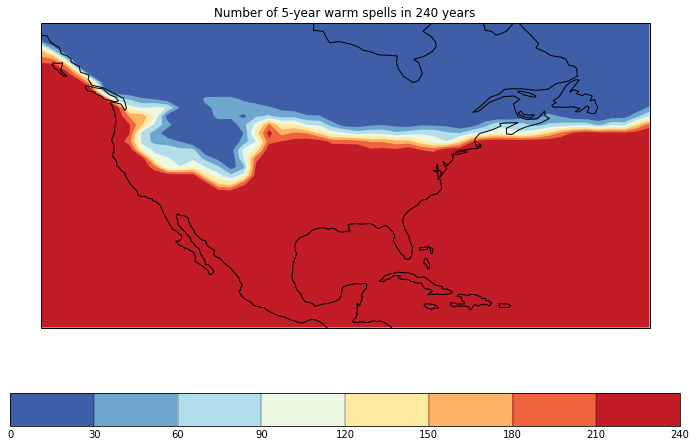

In [19]:
%matplotlib inline
import iris.quickplot as qplt
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = [12, 8]

qplt.contourf(warm_periods, cmap='RdYlBu_r')
plt.gca().coastlines();